In [64]:
#IMPORT MODULES
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gzip
import sys
import os
from collections import defaultdict
from Bio.Blast import NCBIXML
from Bio.SeqFeature import SeqFeature
import subprocess
import gzip
import pypangraph as pp
from collections import Counter
import csv
import re
import networkx as nx
from pyvis.network import Network
from matplotlib.gridspec import GridSpec
from scipy.stats import gamma
import math
from itertools import combinations
import itertools
from functools import lru_cache
from operator import itemgetter


#IMPORT FILES
core_block_alignments='/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTU_core_block_alignments'
combined_core_block_alignments='/Users/jferrare/Documents/Good Lab Work/Gut Phage/March_2025/Combined_vOTU_core_alignments'
hotspot_data='/Users/jferrare/Documents/Good Lab Work/Gut Phage/hotspots.txt'
meta_data='/Users/jferrare/Documents/Good Lab Work/Gut Phage/uhgv_metadata.tsv.gz' #874051 rows
genomes='/Users/jferrare/Documents/Good Lab Work/Gut Phage/uhgv_mgv.fna.gz'
ani_results='/Users/jferrare/Documents/Good Lab Work/Gut Phage/combined_uhgv_mgv_ani.txt' #30700847 rows
blast_results='/Users/jferrare/Documents/Good Lab Work/Gut Phage/combined_uhgv_mgv_blast_results.txt' #165831139 rows
sequence_counts_file='/Users/jferrare/Documents/Good Lab Work/Gut Phage/February_2025/votu_sequence_counts.txt'
ani_columns=['query_id', 'subject_id', 'num_alns', 'percent_identity', 'query_coverage', 'target_coverage']
blast_columns=['query_id','subject_id','percent_identity','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore'] 
meta_columns=['uhgv_genome','uhgv_votu','votu_representative','original_study_alias','original_id','genome_length','is_jumbo_phage','gc_percent','checkv_quality','checkv_completeness','checkv_completeness_method','checkv_trimmed','viral_confidence','genomad_virus_score','genomad_virus_hallmarks','genomad_plasmid_hallmarks','viralverify_prediction','viralverify_score','checkv_viral_markers','checkv_host_markers','cds_count','cds_density','avg_cds_length','genetic_code',	'is_recoded','trna_count_total','trna_count_suppressor','sra_run','sra_sample','biosample','country','latitude','longitude']


In [65]:
#ASSUME MUTATIONS ON ALL BACKGROUNDS ARE POISSON DISTRIBUTED-->EXPONENTIAL DISTRIBUTION OF GAPS BETWEEN SNPS IN TRANSFER REGION
#FIND OPTIMAL PARTITION OF SNPS INTO TRANSFER EVENTS AND CLONAL SNPS BY PENALIZING OVERFITTING WITH AKAIKE INFORMATION CRITERION (AIC)
#AIC WILL BREAK APART A REGION INTO SEPARATE CLONAL SNPS IF THE MEAN >.1586*CLONAL GAP


#MLE ESTIMATOR INITIAL GUESS FOR GENETIC DISTANCE SEPARATING ADJACENT SNPS/TRANSFER EVENTS  (ASSUME EXPONENTIAL)
def predict_clonal_gap(gaps, threshold=300):
    large_gaps = gaps[gaps > threshold]
    # mle estimator for true mean
    predicted_clonal_gap = round(large_gaps.mean() - threshold)
    return predicted_clonal_gap

#LIKELIHOOD OF A NEW TRANSFER EVENT  
def region_likelihood(start, end, polymorphic_sites, clonal_gap):
    region = polymorphic_sites[start:end]
    if len(region) <= 1:
        return 0
    
    sum_of_group = region[-1] - region[0]
    num_gaps = end - start - 1
    
    if sum_of_group / num_gaps < clonal_gap:
        log_likelihood = num_gaps * np.log(num_gaps) - num_gaps * np.log(sum_of_group) - num_gaps
    else:
        log_likelihood = -np.inf
    
    return log_likelihood

#LIKELIHOOD OF A GAP BETWEEN ADJACENT TRANSFER EVENT/SNP OR TRANSFER EVENT/TRANSFER EVENT
def gap_likelihood(gap_value, clonal_gap):
    return -np.log(clonal_gap) - gap_value / clonal_gap

#USE DYNAMIC PROGRAMMING TO IDENTIFY OPTIMAL PARTITION OF POLYMORPHIC SITES IN POLYNOMIAL TIME
def find_optimal_partition_dp(polymorphic_sites,clonal_gap):
    n = len(polymorphic_sites)
    gaps = np.diff(polymorphic_sites)
    
    # Initialize DP tables
    # dp[i] = best AIC for partition ending at i
    dp = [float('inf')] * (n+1)
    # prev[i] = best previous split point for partition ending at i
    prev = [-1] * (n+1)
    
    # Base case
    dp[0] = 0
    
    # Fill DP tables
    for end in range(1, n+1):
        for start in range(end):
            # Calculate likelihood for this segment
            segment_likelihood = region_likelihood(start, end, polymorphic_sites, clonal_gap)
            # Add gap likelihood if this isn't the first segment
            gap_like = 0
            if start > 0:
                gap_like = gap_likelihood(gaps[start-1], clonal_gap)
                segment_length= end - start
                r = 1 if segment_length> 1 else 0
            else:
                gap_like = 0
                r=0
            current_aic = dp[start] - 2 * (segment_likelihood + gap_like) + 2 * r
            
            if current_aic < dp[end]:
                dp[end] = current_aic
                prev[end] = start
    
    
    # Reconstruct the best partition
    partition = []
    i = n 
    while i > 0:
        partition.append(prev[i])
        i = prev[i]
    
    # Convert to the expected format
    partition = sorted([i for i in partition if i > 0])
    return partition

#BUILD PARTITION FROM BREAKPOINTS
def divide_polymorphic_sites(polymorphic_sites, partition):
    # Divide the polymorphic sites into groups based on the partition
    groups = []
    start = 0
    for end in partition:
        groups.append(tuple(polymorphic_sites[start:end]))
        start = end
    groups.append(tuple(polymorphic_sites[start:]))
    return groups

    
#####################################
#calculate summary statistics of transfer event
def evaluate_pair(polymorphic_sites):

    #first iteration using mle estimated clonal
    clonal_gap=predict_clonal_gap(np.diff(polymorphic_sites),threshold=300)
    partition_indices=find_optimal_partition_dp(polymorphic_sites,clonal_gap)
    partition=divide_polymorphic_sites(polymorphic_sites, partition_indices)
    
    #identify learned clonal gap
    gaps=np.diff(polymorphic_sites)
    partition_indices = [x-1 for x in partition_indices]
    clonal_gaps=gaps[partition_indices]
    learned_clonal_gap=np.mean(clonal_gaps)

    #rerun with learned clonal gap`
    partition_indices2=find_optimal_partition_dp(polymorphic_sites,clonal_gap)
    partition2=divide_polymorphic_sites(polymorphic_sites, partition_indices2)
    partition_indices2 = [x-1 for x in partition_indices2]
    clonal_gaps2=gaps[partition_indices2]
    learned_clonal_gap2=np.mean(clonal_gaps2)
    
    #recombined_regions are tuples of length>1 in final_best_partition
    recombined_regions=[region for region in partition2 if len(region)>1]
    #clonal_snps are tuples of length=1 in final_best_partition
    num_clonal_snps=len([region for region in partition2 if len(region)==1])
    num_recombination_events=len(recombined_regions)
    transfer_data=calculate_partition_stats(polymorphic_sites,recombined_regions)
    return transfer_data, clonal_gap, learned_clonal_gap, learned_clonal_gap2,num_clonal_snps,num_recombination_events , partition2


def calculate_partition_stats(polymorphic_sites,recombined_regions):
    transfer_index=1
    transfer_data=[]
    for region in recombined_regions:
        #covert region to string
        region_string=','.join(map(str,region))
        start_index=region[0]-1
        end_index=region[-1]+1
        mean_gap=(region[-1]-region[0])/(len(region)-1)
        transfer_length=region[-1]-region[0]
        heterozygosity=1/mean_gap
        number_snps_in_region=len(region)
        transfer_data.append([transfer_index,start_index,end_index,transfer_length,heterozygosity,number_snps_in_region,mean_gap,region_string])
        transfer_index+=1
    return pd.DataFrame(transfer_data,columns=['transfer_index','start_index','end_index','transfer_length','heterozygosity','num_snps_in_region','mean_gap','gaps'])

#########################
def calculate_AIC_of_partition(partition, clonal_gap):
    # Calculate the likelihood of a partition
    total_AIC = 0
    for region in partition:
        region_like = region_likelihood(0, len(region), region, clonal_gap)
        r = 1 if len(region) > 1 else 0  # Penalize multi-SNP regions only
        total_AIC += -region_like + r  

    region_gaps = [abs(partition[i + 1][0] - partition[i][-1]) for i in range(len(partition) - 1)]
    
    for gap in region_gaps:
        total_AIC += -gap_likelihood(gap, clonal_gap)
    
    return 2 * total_AIC

Final Partition
[(14, 65), (194, 203, 206, 220, 221, 233, 239, 251, 266, 283, 293, 298, 305), (380, 455), (528, 538, 541, 546, 547, 556, 571), (1085, 1118, 1124, 1141, 1144, 1147, 1156, 1157, 1158, 1159, 1160, 1176, 1205, 1206, 1244), (1449,), (1828, 1834), (5055, 5058, 5061, 5072, 5076, 5079), (5151, 5166, 5187, 5196), (5781, 5784), (6153,), (6774, 6775, 6778, 6779, 6780, 6781, 6782, 6783, 6784, 6785, 6786, 6787, 6788, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6796, 6797, 6798), (6900, 7227, 7264, 7474), (7790, 7840, 7870, 7877, 7927, 8004, 8027, 8029, 8087, 8088, 8092, 8096, 8133, 8217), (9372, 9399, 9414, 9422, 9444), (9603,), (10540,), (10741, 10766), (11154, 11156, 11191, 11194, 11220, 11224, 11230, 11233, 11236, 11239, 11242, 11251, 11268), (11584, 11590, 11602, 11605, 11606, 11608, 11611, 11629, 11632, 11635), (12016,), (12174, 12215, 12264, 12269, 12309, 12326, 12342, 12344, 12400, 12452, 12464, 12517, 12549), (12871, 12929), (14934, 14940, 14958), (15311,), (17717, 17718, 1771

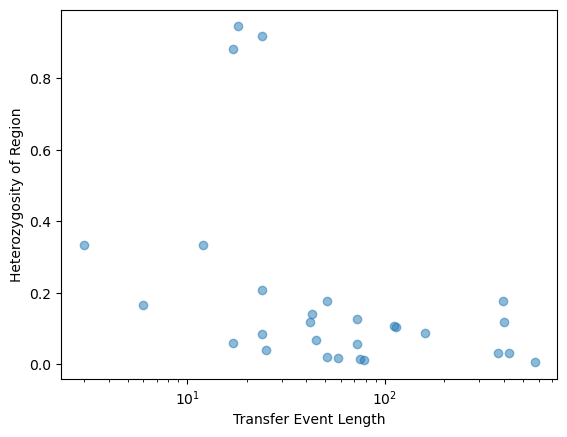

In [62]:
#EXAMPLE
############################
polymorphic_sites=np.asarray([   14,    65,   194,   203,   206,   220,   221,   233,   239,  251,   266,   283,   293,   298,   305,   380,   455,   528,
         538,   541,   546,   547,   556,   571,  1085,  1118,  1124,1141,  1144,  1147,  1156,  1157,  1158,  1159,  1160,  1176,
        1205,  1206,  1244,  1449,  1828,  1834,  5055,  5058,  5061, 5072,  5076,  5079,  5151,  5166,  5187,  5196,  5781,  5784,
        6153,  6774,  6775,  6778,  6779,  6780,  6781,  6782,  6783,6784,  6785,  6786,  6787,  6788,  6789,  6790,  6791,  6792,
        6793,  6794,  6795,  6796,  6797,  6798,  6900,  7227,  7264,7474,  7790,  7840,  7870,  7877,  7927,  8004,  8027,  8029,
        8087,  8088,  8092,  8096,  8133,  8217,  9372,  9399,  9414, 9422,  9444,  9603, 10540, 10741, 10766, 11154, 11156, 11191,
       11194, 11220, 11224, 11230, 11233, 11236, 11239, 11242, 11251, 11268, 11584, 11590, 11602, 11605, 11606, 11608, 11611, 11629,
       11632, 11635, 12016, 12174, 12215, 12264, 12269, 12309, 12326,12342, 12344, 12400, 12452, 12464, 12517, 12549, 12871, 12929,
       14934, 14940, 14958, 15311, 17717, 17718, 17719, 17720, 17722, 17723, 17724, 17726, 17727, 17728, 17729, 17730, 17731, 17732,
       17733, 17734, 17793, 17794, 17795, 17796, 17797, 17798, 17799, 17800, 17801, 17802, 17803, 17804, 17805, 17806, 17807, 17808,
       17809, 17811, 18539, 20308, 32094, 32119, 32120, 32121, 32130, 32136, 32226, 32304, 32355, 32358, 32361, 32364, 32367, 32415,
       32421, 32427, 32430, 32433, 32448, 32453, 32454, 32472, 32480,32502, 32504, 32505, 32511, 32513, 32517, 32526, 32538, 32540,
       32541, 32544, 32547, 32562, 32583, 32586, 32601, 32607, 32610, 32618, 32630, 32631, 32634, 32657, 32664, 32673, 32691, 32727,
       32730, 32733, 32736, 32758, 32769, 32784, 32793, 32796, 32802, 32805, 32817, 33507, 33524, 33745, 33924, 33936, 33957, 33960,
       33963, 33972, 33978, 33990, 33993, 33996, 34044, 34045, 34047, 34050, 34062, 34068, 34074, 34077, 34080, 34083, 34092, 34095,
       34101, 34104, 34122, 34125, 34126, 34131, 34137, 34140, 34146, 34149, 34150, 34152, 34155, 34161, 34164, 34167, 34170, 34175,
       34179, 34185, 34194, 34206, 34209, 34215, 34218, 34219, 34242, 34251, 34263, 34272, 34281, 34284, 34288, 34290, 34296, 34297,
       34299, 34302, 34305, 34320, 34323, 34327, 34329, 34353, 34357, 34359, 34365, 34368, 34374, 34379, 34380, 34381, 34382, 34404,
       34413, 34431, 34432, 34439, 34440, 36441])



transfer_data, clonal_gap, learned_clonal_gap, learned_clonal_gap2,num_clonal_snps,num_recombination_events, partition2=evaluate_pair(polymorphic_sites)
print("Final Partition")
print(partition2)
plt.scatter(transfer_data['transfer_length'], transfer_data['heterozygosity'], alpha=0.5)
plt.xscale('log')
plt.xlabel('Transfer Event Length')
plt.ylabel('Heterozygosity of Region')
plt.show()





In [66]:

def count_zero_snp_windows(L, w, snp_positions):
    total_windows = L - w + 1
    affected = np.zeros(total_windows, dtype=bool)
    
    for p in snp_positions:
        start = max(0, p - w)
        end = min(total_windows, p)
        affected[start:end] = True  # Vectorized marking
    
    return np.count_nonzero(~affected)



def process_alignment(file_path, output_dir):
    w=300
    sequences = {record.id: np.array(list(str(record.seq))) for record in SeqIO.parse(file_path, "fasta")}
    seq_ids = list(sequences.keys())
    
    votu_name = os.path.splitext(os.path.basename(file_path))[0]  # Extract vOTU name
    
    count_over_80 = 0
    clonal_v_recombined = []
    votu_dir = os.path.join(output_dir, votu_name)
    os.makedirs(votu_dir, exist_ok=True)
    recombination_file = os.path.join(votu_dir, f"{votu_name}_recombination_events.txt")
    if os.path.exists(recombination_file):
        return None
    with open(recombination_file, "w") as r_f:
        r_f.write("seq1\tseq2\ttransfer_index\ttransfer_start\ttransfer_end\ttransfer_length\theterozygosity\2tsnps_in_transfer\tgaps_in_transfer\n")

        for seq1, seq2 in combinations(seq_ids, 2):
            s1, s2 = sequences[seq1], sequences[seq2]
            s1_o=s1
            s2_o=s2
            # Remove gap sites from both sequences
            valid_sites = (s1 != '-') & (s2 != '-')
            s1, s2 = s1[valid_sites], s2[valid_sites]
            differing_sites = np.where(s1 != s2)[0]  
            identical_windows = count_zero_snp_windows(len(s1), w, differing_sites)
            fraction_identical = identical_windows / (len(s1) - w + 1)
            gaps=np.diff(differing_sites)
            #count gaps bigger than 300
            large_gaps=gaps[gaps>300]
            
            if fraction_identical > 0.6 and len(differing_sites) > 2 and len(large_gaps)>0:
                count_over_80 += 1
                #create mapping of filtered sequence position to original sequence position
                filtered_seq_pos_to_original_pos={}
                #create dictionary where site index in s1 is key and corresponding site in s1_o is value
                count=0
                for i in range(0,len(s1_o)):
                    if s1_o[i]!='-':
                        filtered_seq_pos_to_original_pos[count]=i
                        count+=1
                genome_length=len(s1_o)
                number_of_snps=len(differing_sites)

                transfer_data, initial_clonal_gap, learned_clonal_gap, learned_clonal_gap2,num_clonal_snps,num_recombination_events, partition=evaluate_pair(differing_sites)
            
                clonal_v_recombined.append([seq1, seq2,genome_length,number_of_snps,fraction_identical,num_recombination_events, num_clonal_snps, initial_clonal_gap, learned_clonal_gap, learned_clonal_gap2])
                #columns=['transfer_index','start_index','end_index','transfer_length','heterozygosity','num_snps_in_region','mean_gap','gaps']
                for i, row in transfer_data.iterrows():
                    transfer_event_index=row['transfer_index']
                    transfer_start=min(row['start_index'],len(s1)-1)
                    transfer_end=max(0,row['end_index'])
                    transfer_start_o=filtered_seq_pos_to_original_pos[transfer_start]
                    transfer_end_o=filtered_seq_pos_to_original_pos[transfer_end]
                    transfer_length=row['transfer_length']
                    number_snps_in_region=row['num_snps_in_region']
                    heterozygosity=row['heterozygosity']
                    gaps=row['gaps']
                    r_f.write(f"{seq1}\t{seq2}\t{transfer_event_index}\t{transfer_start_o}\t{transfer_end_o}\t{transfer_length}\t{heterozygosity}\t{number_snps_in_region}\t{gaps}\n")
            
    recombination_file2 = os.path.join(votu_dir, f"{votu_name}_close_pair_data_{count_over_80}.txt")

    with open(recombination_file2, "w") as r_f:
        r_f.write("seq1\tseq2\tgenome_length\tnumber_of_snps\tfraction_identical\tnum_events\tnum_clonal_snps\tinitial_gap\tsecond_gap\third_gap\n")
        for row in clonal_v_recombined:
            seq1, seq2,genome_length,number_of_snps,fraction_identical,num_recombination_events, num_clonal_snps, initial_clonal_gap, learned_clonal_gap, learned_clonal_gap2 = row
            r_f.write(f"{seq1}\t{seq2}\t{genome_length}\t{number_of_snps}\t{fraction_identical}\t{num_recombination_events}\t{num_clonal_snps}\t{initial_clonal_gap}\t{learned_clonal_gap}\t{learned_clonal_gap2}\n")


                
def process_all_files(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for file_name in os.listdir(input_dir):
        if file_name.endswith(".fna"):  # Process only fasta files
            file_path = os.path.join(input_dir, file_name)
            process_alignment(file_path, output_dir)

# Example usage:
input_dir = "/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTU_core_genome_alignments"
output_dir = "/Users/jferrare/Documents/Good Lab Work/Gut Phage/April_2025/HGT_events"
process_all_files(input_dir, output_dir)